In [1]:
from setup_env import setup_environment

setup_environment()

In [2]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from project.machine_learning.classifier import ClassifierJudge
from project.machine_learning.model_mc import ModelMC
from project.wfc.factory import Factory
from project.wfc.grid import Grid, Rect
from project.wfc.history import History
from project.wfc.judge import RandomJudge, Judge
from project.config import DATA_SOURCE
from project.wfc.wfc import WFC

In [3]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [4]:
factory = Factory(DATA_SOURCE)
patterns = factory.create_patterns()

INFO - Validation Result: success



In [5]:
def evaluate_wfc(
    sizes: np.ndarray, target_successes: int, judge: Judge, name: str
) -> pd.DataFrame:
    results = []

    for size in tqdm(sizes):
        rect = Rect(width=size, height=size)
        grid = Grid(rect=rect, patterns=patterns)
        history = History(capacity=-1)
        wfc = WFC(grid=grid, judge=judge, history=history)

        successes = 0
        tries = 0

        while successes < target_successes:
            is_succeeded = False

            while not is_succeeded:
                tries += 1
                is_succeeded = wfc.generate()

            successes += 1

        mean_tries = tries / target_successes
        results.append({"model": name, "size": size**2, "mean_tries": mean_tries})

    return pd.DataFrame(results)

In [11]:
sizes = np.arange(2, 12)
target_successes = 100

In [12]:
random_judge = RandomJudge()

wfc_df = evaluate_wfc(sizes, target_successes, random_judge, "Classic WFC")

wfc_df.head(5)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


,model,size,mean_tries
0,Classic WFC,4,1.00
1,Classic WFC,9,1.06
2,Classic WFC,16,1.20
3,Classic WFC,25,1.38
4,Classic WFC,36,2.26


In [13]:
dt_judge = ClassifierJudge(view=Rect(width=3, height=3), threshold=0.5, rebalance=True)
dt_judge.load_weights("weights/dtree/logistic_regression.pkl")

wfcwdt_df = evaluate_wfc(sizes, target_successes, dt_judge, "WFC with Decision Tree")

wfcwdt_df.head(5)

100%|██████████| 10/10 [00:52<00:00,  5.27s/it]


,model,size,mean_tries
0,WFC with Decision Tree,4,1.01
1,WFC with Decision Tree,9,1.03
2,WFC with Decision Tree,16,1.17
3,WFC with Decision Tree,25,1.40
4,WFC with Decision Tree,36,1.96


In [8]:
mc_judge = ModelMC(view=Rect(3, 3))
mc_judge.load_weights("data/weights/wfcwmc/mmc_1000")

wfcwmc_df = evaluate_wfc(sizes, target_successes, mc_judge, "WFCWMC")

wfcwmc_df.head(5)

100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


,model,size,mean_tries
0,WFCWMC,4,1.00
1,WFCWMC,9,1.02
2,WFCWMC,16,1.06
3,WFCWMC,25,1.08
4,WFCWMC,36,1.16


In [14]:
evaluation_df = pd.concat([wfc_df, wfcwdt_df]).reset_index(drop=True)

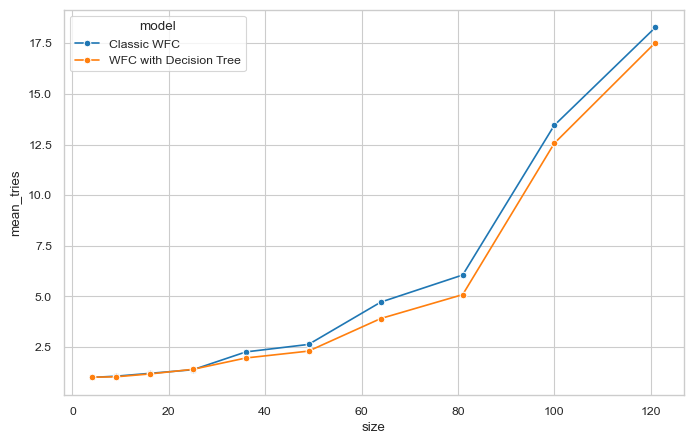

In [15]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=evaluation_df, x="size", y="mean_tries", hue="model", marker="o")
plt.savefig("content/performance.png", bbox_inches="tight")